## Basis Swap Par Spreads

The goal of the project is to compute the par spreads of a pool of basis swaps, i.e. those contracts in which two floating IBOR rates, with different tenors, are exchanged. The par spread is that margin which has to be paid/received on top of the floating rate with the shorter tenor.

The input parameters are:

* the par rate of a set of Overnight Index Swaps (i.e. their market quotation);
* 3 sets of forward libor rates and their fixing dates, one each for EURIBOR 1M, 3M and 6M;
* the static data of the pool of swaps (nominal, maturity, tenor of the first and second leg).

### Notes and hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for multi-curve evaluation.

Remember to reuse the code we developed during the lessons in `finmarkets.py` as much as possible, instead of trying to rewrite everything from scratch!

When not possible develop your own classes.

In [ ]:
from pdf2image import convert_from_path

images = convert_from_path("https://drive.google.com/file/d/1vqdBb0Mx3X2Fc-PFqu1rt6WHAmJzaMsz/view?usp=share_link")
images[0]  # first page

In [2]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/Projects')

Mounted at /content/drive


In [3]:
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
from finmarkets import ForwardRateCurve

today = date.today()


ois_quotes = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/Projects/ois_quotes.xlsx")

df = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/Projects/euribor_curve.xlsx", sheet_name="EURIBOR1M")

df = pd.ExcelFile("https://github.com/matteosan1/finance_course/raw/develop/Projects/euribor_curve.xlsx")
print (df.sheet_names)

euribor_curves = {}
euribor = df.parse("EURIBOR1M")
dates = [today + relativedelta(months=i) for i in euribor.loc[:, 'months']]
euribor_curves[1] = ForwardRateCurve(dates, euribor['rates']*0.01)

euribor = df.parse("EURIBOR3M")
dates = [today + relativedelta(months=i) for i in euribor.loc[:, 'months']]
euribor_curves[3] = ForwardRateCurve(dates, euribor['rates']*0.01)

euribor = df.parse("EURIBOR6M")
dates = [today + relativedelta(months=i) for i in euribor.loc[:, 'months']]
euribor_curves[6] = ForwardRateCurve(dates, euribor['rates']*0.01)

basis_swaps = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/basis_swaps_proj1.csv")
print (basis_swaps.head())

['EURIBOR1M', 'EURIBOR3M', 'EURIBOR6M', 'USDLIBOR3M']
   first_tenor  second_tenor  maturity  nominal
0            1             3        12  1000000
1            3             6        12  1500000
2            1             6        12  1500000
3            1             3        24  1000000
4            3             6        24  1000000


First of all we need to determine the discount curve from the OIS market quotes using the bootstrap technique.

* generate set of OIS according to the market quotes
* create an objective function with a discount curve and the squared sum of NPVs
* check minimization results
* create the found `DiscountCurve`

In [4]:
from finmarkets import OvernightIndexSwap
pillar_dates = [today]

swaps = []
for q in range(len(ois_quotes)):
  swap = OvernightIndexSwap(1e6, today, 
                            ois_quotes.loc[q, 'quotes']*0.01,
                            ois_quotes.loc[q, 'months'])
  swaps.append(swap)
  pillar_dates.append(swap.payment_dates[-1])

In [5]:
from finmarkets import DiscountCurve
import numpy as np

def objective_function(x):
    x = np.insert(x, 0, 1)
    curve = DiscountCurve(pillar_dates, x)
    
    sum_sq = 0.0
    for swap in swaps:
        sum_sq += swap.npv(curve) ** 2
        
    return sum_sq

In [6]:
from scipy.optimize import minimize

x0 = [.5 for i in range(len(swaps))]
bounds = [(0.01, 10.0) for i in range(len(x0))]

result = minimize(objective_function, x0, bounds=bounds)

In [7]:
print (result)
print (objective_function(x0))
print (objective_function(result.x))

      fun: 0.0006013599992417439
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.63938899e-02,  1.38223346e+02,  2.30556634e+02,  2.57844061e+02,
        2.17193616e+02,  1.33159437e+02,  3.08937082e+01, -5.95497255e+01,
       -1.13576675e+02, -1.27439287e+02, -9.99847176e+01, -9.79217600e+02,
       -1.74674145e+02,  4.02044366e+02,  2.72031572e+02,  2.03666431e+02,
        1.56196360e+02,  1.77371852e+02,  1.94538167e+02,  2.27948331e+02,
        2.62082196e+02,  3.03009575e+02,  2.92437520e+02, -9.98009801e+01,
       -1.32677905e+02, -1.42189738e+03,  6.89251810e+01,  5.40960332e+02,
       -7.84842209e+02, -1.33500633e+02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 775
      nit: 10
     njev: 25
   status: 0
  success: True
        x: array([0.9994318 , 0.99831201, 0.99692945, 0.99525677, 0.99335846,
       0.99136706, 0.9892002 , 0.98691644, 0.98469213, 0.98233439,
       0.98001276, 0.97763573, 0.9638143 , 0.95044587

In [8]:
dfs = np.insert(result.x, 0, 1)
ois_curve = DiscountCurve(pillar_dates, dfs)

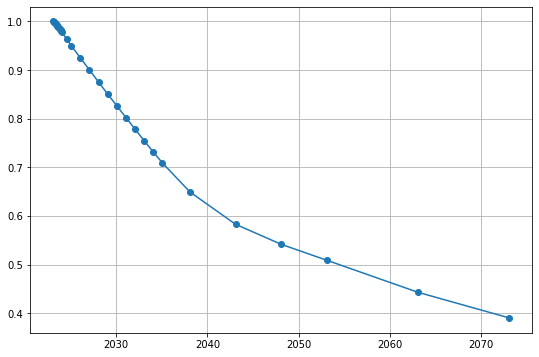

In [9]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (9, 6)
plt.plot(pillar_dates, dfs, marker='o')
plt.grid(True)
plt.show()

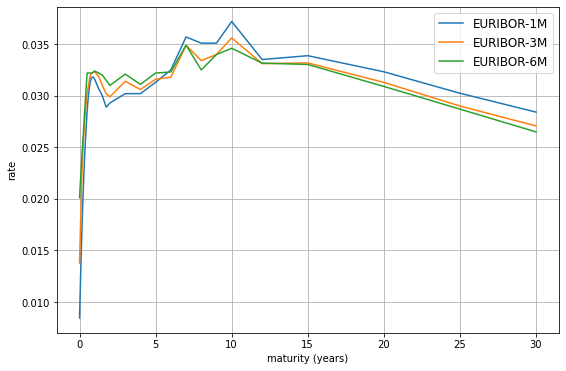

In [10]:
from finmarkets import ForwardRateCurve

for k in euribor_curves.keys():
  plt.plot(euribor_curves[k].pillar_dates, euribor_curves[k].rates, label="EURIBOR-{}M".format(k))

plt.grid(True)
plt.xlabel("maturity (years)")
plt.ylabel("rate")
plt.legend(fontsize=12)
plt.show()

Create a BasisSwap class that has a method to compute the fair margin as follows:

$$S = \frac {S_{t2} - S_{t1}}{\text{annuity}_{t1}} $$

In [13]:
from datetime import date
from dateutil.relativedelta import relativedelta
from finmarkets import generate_dates

class BasisSwap:
    def __init__(self, notional, start_date,
                 maturity, tenor1, tenor2):
    
        #self.start_date = start_date
        self.notional = notional
        #self.maturity = maturity
        self.tenor1 = tenor1
        self.tenor2 = tenor2
    
        self.tenor1_payment_dates = generate_dates(start_date, maturity, tenor1)
        self.tenor2_payment_dates = generate_dates(start_date, maturity, tenor2)

    def swap_rate(self, pd, dc, euribor, corr=0):
        sp = 0 
        for i in range(1, len(pd)):
            F = euribor.forward_rate(pd[i-1], pd[i]) + corr
            D = dc.df(pd[i])
            tau = (pd[i] - pd[i-1]).days / 360
            sp += F * D * tau
        return sp
        
    def annuity(self, payment_dates, dc):
        annuity_ft = 0
        for j in range(1, len(payment_dates)):
            D = dc.df(payment_dates[j])
            tau = (payment_dates[j] - payment_dates[j-1]).days/360
            annuity_ft += D * tau
        return annuity_ft
        
    def fair_margin(self, discount_curve, euribor_1t, euribor_2t):
        s2 = self.swap_rate(self.tenor2_payment_dates, discount_curve, euribor_2t)
        s1 = self.swap_rate(self.tenor1_payment_dates, discount_curve, euribor_1t) 
        delta_sp = s2 - s1
        
        annuity_ft = self.annuity(self.tenor1_payment_dates, discount_curve)
        return (delta_sp / annuity_ft)
    
    def fair_npv(self, discount_curve, euribor_1t, euribor_2t):
        par_spread = self.fair_margin(discount_curve, euribor_1t, euribor_2t)
        npv2 = self.swap_rate(self.tenor2_payment_dates, discount_curve, euribor_2t)
        npv1 = self.swap_rate(self.tenor1_payment_dates, discount_curve, euribor_1t, par_spread)
        
        return (npv2 - npv1)* self.notional
    
    def fair_npv_with_par(self, par_spread, discount_curve, euribor_1t, euribor_2t):
        npv2 = self.swap_rate(self.tenor2_payment_dates, discount_curve, euribor_2t)
        npv1 = self.swap_rate(self.tenor1_payment_dates, discount_curve, euribor_1t, par_spread)
        
        return (npv2 - npv1)* self.notional        

    def npv(self, discount_curve, euribor_1t, euribor_2t):
        par_spread = self.fair_margin(discount_curve, euribor_1t, euribor_2t)
        npv2 = self.swap_rate(self.tenor2_payment_dates, discount_curve, euribor_2t)
        npv1 = self.swap_rate(self.tenor1_payment_dates, discount_curve, euribor_1t)
        
        return (npv2 - npv1)* self.notional

In [14]:
par_spreads = []

for i in range(len(basis_swaps)):
  bs = BasisSwap(basis_swaps.loc[i, 'nominal'], today,
                 basis_swaps.loc[i, 'maturity'],
                 basis_swaps.loc[i, 'first_tenor'],
                 basis_swaps.loc[i, 'second_tenor'])

  print (bs.npv(ois_curve, euribor_curves[bs.tenor1], 
                euribor_curves[bs.tenor2]))
  par_spreads.append(bs.fair_margin(ois_curve,  
                                    euribor_curves[bs.tenor1],
                                    euribor_curves[bs.tenor2]))
  break
print ("Par spreads: " + str(["{:.5f}".format(s) for s in par_spreads]))

644.6213360604484
Par spreads: ['0.00064']


In [ ]:
bs = BasisSwap(basis_swaps.loc[2, 'nominal'], today, 
               basis_swaps.loc[2, 'maturity'], 
               basis_swaps.loc[2, 'first_tenor'],
               basis_swaps.loc[2, 'second_tenor'])

In [ ]:
bs.fair_npv(ois_curve, euribor_curves[bs.tenor1], euribor_curves[bs.tenor2])


1.0408340855860843e-11

In [ ]:
bs.npv(ois_curve, euribor_curves[bs.tenor1], euribor_curves[bs.tenor2])

-986.1140872625372

### Alternative solution with brentq

In [ ]:
from scipy.optimize import brentq

for i in range(len(basis_swaps)):
    bs = BasisSwap(basis_swaps.loc[i, 'nominal'], today,
                       basis_swaps.loc[i, 'maturity'],
                       basis_swaps.loc[i, 'first_tenor'],
                       basis_swaps.loc[i, 'second_tenor'])
    ps = brentq(bs.fair_npv_with_par, -1, 1, 
                args=(ois_curve, euribor_curves[bs.tenor1], euribor_curves[bs.tenor2]))
    print ("{:.5f}".format(ps))

0.00064
0.00001
0.00066
0.00055
0.00099
0.00154
0.00026
0.00050
0.00075
-0.00120
-0.00047
-0.00167
-0.00154
-0.00098
-0.00252
